## Data Cleaning

### Data Gaps
As a first step, we need to ensure that the data is consistent, i.e., that there are no significant gaps. As we can see we have no data entries between May 15 th 2023 and December 29th 2023.

In [594]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

# ticks
df_eth = pd.read_csv("./data/historical_candles_HL/eth_candles.csv").sort_values(by="date_open")
df_btc = pd.read_csv("./data/historical_candles_HL/btc_candles.csv").sort_values(by="date_open")
df_sol = pd.read_csv("./data/historical_candles_HL/sol_candles.csv").sort_values(by="date_open")

# funding
eth_funding = pd.read_csv("./data/historical_funding_HL/eth_funding_rates.csv").sort_values(by="date")
btc_funding = pd.read_csv("./data/historical_funding_HL/btc_funding_rates.csv").sort_values(by="date")
sol_funding = pd.read_csv("./data/historical_funding_HL/sol_funding_rates.csv").sort_values(by="date")

# orderbook
eth_orderbook = pd.read_csv("./data/historical_orderbooks_HL/eth_orderbook.csv").sort_values(by="date")
btc_orderbook = pd.read_csv("./data/historical_orderbooks_HL/btc_orderbook.csv").sort_values(by="date")
sol_orderbook = pd.read_csv("./data/historical_orderbooks_HL/sol_orderbook.csv").sort_values(by="date")

# find gaps in data by resampling
df_eth_time_index = df_eth.set_index(pd.DatetimeIndex(df_eth["date_close"]))
df_eth_resample = df_eth_time_index["close"].resample("1D").last().reset_index(name="last")
empty_eth = df_eth_resample.loc[df_eth_resample["last"].isna()]

df_btc_time_index = df_btc.set_index(pd.DatetimeIndex(df_btc["date_close"]))
df_btc_resample = df_btc_time_index["close"].resample("1D").last().reset_index(name="last")
empty_btc = df_btc_resample.loc[df_btc_resample["last"].isna()]

df_sol_time_index = df_sol.set_index(pd.DatetimeIndex(df_sol["date_close"]))
df_sol_resample = df_sol_time_index["close"].resample("1D").last().reset_index(name="last")
empty_sol = df_sol_resample.loc[df_sol_resample["last"].isna()]

# combined 
pd.merge(empty_eth, empty_btc, on="date_close").merge(empty_sol, on="date_close")

,date_close,last_x,last_y,last
0,2023-05-15,NaN,NaN,NaN
1,2023-05-16,NaN,NaN,NaN
2,2023-05-17,NaN,NaN,NaN
3,2023-05-18,NaN,NaN,NaN
4,2023-05-19,NaN,NaN,NaN
...,...,...,...,...
224,2023-12-25,NaN,NaN,NaN
225,2023-12-26,NaN,NaN,NaN
226,2023-12-27,NaN,NaN,NaN
227,2023-12-28,NaN,NaN,NaN


### Data Entries

Next, we want to ensure that the tick data is consistent amongst the remaining data. We group the tick data by data and see that for Solana there are inconsistencies for December 30th and February 21st. For that reason we will be working with data from December 31st to February 20th.

In [595]:
df_eth_entries = df_eth.groupby(pd.to_datetime(df_eth["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_eth")
df_btc_entries = df_btc.groupby(pd.to_datetime(df_btc["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_btc")
df_sol_entries = df_sol.groupby(pd.to_datetime(df_sol["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_sol")

# combined
df_merged = pd.merge(df_eth_entries, df_btc_entries, on="date_close").merge(df_sol_entries, on="date_close")
df_merged["eq"] = df_merged.apply(lambda x: x.count_eth == x.count_btc == x.count_sol, axis=1)
df_merged.loc[df_merged["eq"]==False]

,date_close,count_eth,count_btc,count_sol,eq
3,2023-12-30,41,41,37,False
56,2024-02-21,3,3,5,False


## Data Analysis

### Correlation and Co-Integration

Now that we have our working data set, we can implement the trading strategy. First, we will check for correlations amongst the pairs and see that BTC&SOL are highly correlated.

In [596]:
# cut off data
df_eth = df_eth[(pd.to_datetime(df_eth["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_eth["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()
df_btc = df_btc[(pd.to_datetime(df_btc["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_btc["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()
df_sol = df_sol[(pd.to_datetime(df_sol["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_sol["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()

prices_combined = pd.concat([df_eth["close"], df_btc["close"], df_sol["close"]], axis=1, ignore_index=True)
prices_combined.columns = [["eth_close", "btc_close", "sol_close"]]

corr_matrix = prices_combined.corr()
corr_matrix

,eth_close,btc_close,sol_close
eth_close,1.000000,0.803223,0.648805
btc_close,0.803223,1.000000,0.859498
sol_close,0.648805,0.859498,1.000000


### Co-Integration

To really establish a relationship between two time series, we will be investigating whether any of the pairs are co-integrated. Given that prices by themselves are non-stationary, we will be looking at the spread which we define as $$spread = log(a) - nlog(b)$$

We see that based on the 15-minute data, SOL and BTC are co-integrated.

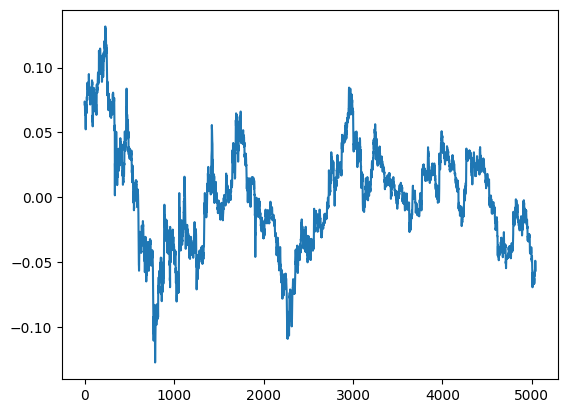

p-value: 0.013680699073663823, test statistic: -3.3277984285121147


In [597]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# investigate the spread between the logs

# run pairwise cointegration test
def cointegrated_pairs(data):
    n = data.shape[1]
    scores = np.zeros((n, n))
    p_values = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            scores[i, j] = score
            p_values[i, j] = pvalue
            print(p_values)
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return(scores, p_values, pairs)

# set log of price for all three currencies
df_eth["log_close"] = np.log(df_eth["close"])
df_btc["log_close"] = np.log(df_btc["close"])
df_sol["log_close"] = np.log(df_sol["close"])

Y = df_sol["log_close"]
X = df_btc["log_close"]

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
# Y is sol, X is btc
errors = Y - (alpha + X['log_close'] * beta)

errors.plot()
plt.show()

dftest = adfuller(errors, maxlag=1)
print(f"p-value: {dftest[1]}, test statistic: {dftest[0]}")

### Signal Generation

For the signal, we will be looking at the z-score. We can then assess the threshold that we want in order to create the corresponding trading signal. In essence, what we are trying to accomplish is to long the spread when the z-score falls below our threshold of -1 and short the spread whenever it crosses 1. 

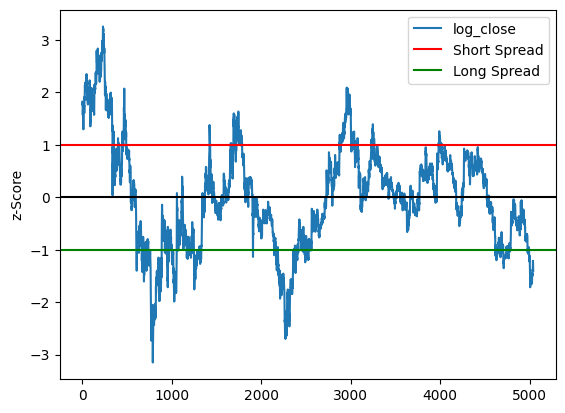

In [598]:
# calculate z score
spread = errors
z = (spread - np.mean(spread))/np.std(spread)
z.plot()
plt.axhline(z.mean(), color="black")
plt.axhline(1.0, color="red", label="Short Spread")
plt.axhline(-1.0, color="green", label="Long Spread")
plt.ylabel("z-Score")
plt.legend()
plt.show()

### Backtesting

Next, we assess the viability of the trading strategy. Based on the above thresholds, the corresponding buy/sell signals would be the following:

* Buy signal (long the spread): when z-score <= -1 
* Sell signal (short the spread): when z-score >= 1
* Close position when we cross 0

Based on the trades from December 31st to February 16th we have a gross profit of 5.39%.

In [599]:
import math

trades = pd.DataFrame()
trades["signal"] = z
trades["pos"] = spread
trades["side"] = 0.0

trades.loc[trades["signal"] <= -1, "side"] = 1
trades.loc[trades["signal"] >= 1, "side"] = -1
# set axis for better readability
trades.index = pd.DatetimeIndex(df_btc["date_close"])
returns = pd.DataFrame()
returns["gross"] = trades.pos.pct_change() * trades.side/100


cur = None
entry_signal = 1
exit_signal = 0
counter = -1

df_backtest = pd.concat([trades.reset_index(), df_sol["close"], df_btc["close"]], axis=1)
df_backtest.columns = ["date_close", "signal", "pos", "side", "sol", "btc"]
returns = []
res = []
for i, sig in df_backtest.iterrows():
    counter += 1
    date, s, spread, side, sol, btc = sig
    if not cur:
        # long
        if s <= -1:
            cur = "long"
            res.append([date, "enter long", s, spread, side, sol, btc])
        # short
        elif s >= 1:
            cur = "short"
            res.append([date, "enter short", s, spread, side, sol, btc])
    
    # signal is to long spread, i.e., long sol, short btc
    if s <= -1:
        # if we hold current short, else do nothing
        if cur == "short":
            # flip to long else hold
            res.append([date, "enter long", s, spread, side, sol, btc])
            cur = "long"
                    
    # signal is to short spread, i.e., short sol, long btc
    elif s >= 1:
        # if we hold current long, else do nothing
        if cur == "long":
            # flip to short else hold
            res.append([date, "enter short", s, spread, side, sol, btc])
            cur = "short"
    
    # check if we cross 0 and exit positions
    else:
        if df_backtest["signal"][counter-1] > 0 and df_backtest["signal"][counter] <= 0:
            if cur == "long":
                # close long
                cur = None
                res.append([date, "close long", s, spread, 1, sol, btc])
                # calculate the profit for our long
                profit_a1 = df_backtest["sol"][counter-1]/df_backtest["sol"][counter]-1.
                profit_a2 = df_backtest["btc"][counter-1]/df_backtest["btc"][counter]-1.
                returns.append([date, profit_a1, -profit_a2])
            
        elif df_backtest["signal"][counter-1] < 0 and df_backtest["signal"][counter] >= 0:
            if cur == "short":
                # close short
                cur = None
                profit_a1 = df_backtest["sol"][counter-1]/df_backtest["sol"][counter]-1.
                profit_a2 = df_backtest["btc"][counter-1]/df_backtest["btc"][counter]-1.
                returns.append([date, -profit_a1, profit_a2])
                res.append([date, "close short", s, spread, -1, sol, btc])

df_res = pd.DataFrame(res)
df_res.columns = ["date", "signal", "Z", "spread", "side", "sol_close", "btc_close"]
df_results = pd.DataFrame(returns)
df_results["total"] = df_results[1] + df_results[2]
total_returns = df_results["total"].sum()
print(f"Returns based on backtesting results: {total_returns*100:.2f}%")
df_res["date"] = pd.to_datetime(df_res["date"])
df_res

Returns based on backtesting results: 5.39%


,date,signal,Z,spread,side,sol_close,btc_close
0,2023-12-31 00:29:59,enter short,1.768772,0.071532,-1.0,102.260,42287.0
1,2024-01-05 15:14:59,close short,0.026755,0.001082,-1.0,98.290,43798.0
2,2024-01-06 06:14:59,enter long,-1.034746,-0.041847,1.0,93.865,43642.0
3,2024-01-10 22:44:59,close long,-0.079892,-0.003231,1.0,103.060,46452.0
4,2024-01-11 01:59:59,enter long,-1.016098,-0.041093,1.0,99.428,46557.0
5,2024-01-11 14:29:59,close long,-0.138876,-0.005616,1.0,105.680,47928.0
6,2024-01-12 01:29:59,enter long,-1.154137,-0.046675,1.0,97.765,45963.0
7,2024-01-13 21:29:59,close long,-0.030610,-0.001238,1.0,96.299,42903.0
8,2024-01-14 16:29:59,enter short,1.376286,0.055659,-1.0,101.960,42914.0
9,2024-01-15 00:14:59,close short,0.153458,0.006206,-1.0,95.395,42087.0


To calculate the net returns, we need to include the fees on Hyperliquid. These are trading fees that have to be paid. Our net returns amount to 5.2%.

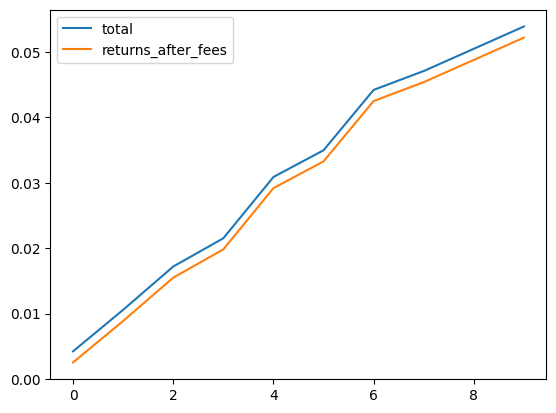

In [600]:
# taken from https://hyperliquid.gitbook.io/hyperliquid-docs/trading/fees
# assuming lowest volume tier
fee = 0.00035
# estimation for a size of 100k per side, therefore limitation
slippage = 0.0005


# per trade, there are twice the fee as well as slippage
df_results["total"] = df_results["total"].cumsum()
df_results["returns_after_fees"] = df_results["total"] * 1-(2*(fee+slippage))

plt.yticks(np.arange(-0.1, 0.1, step=0.01))
df_results["total"].plot()
df_results["returns_after_fees"].plot()
plt.legend()

# export results
df_results.columns = ["date", "profit_a1", "profit_a2", "total", "total_post_fees"]
df_results.to_csv("returns.csv")

### Orderbook Analysis

Given that the returns above only take static sizing and corresponding slippage into account, we can improve the model by looking into the orderbook for SOL & BTC. First, we need to clean the data. This includes only including the dates that are of interest to us as well as identifying the asks/bids at a given time.

In [601]:
import json
# set ranges for order book analysis
sol_orderbook = sol_orderbook[(pd.to_datetime(sol_orderbook["date"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(sol_orderbook["date"]) < dt.datetime(2024, 2, 21))].reset_index(drop=True)
btc_orderbook = btc_orderbook[(pd.to_datetime(btc_orderbook["date"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(btc_orderbook["date"]) < dt.datetime(2024, 2, 21))].reset_index(drop=True)

# make orderbook "readable"
sol_orderbook["levels"] = sol_orderbook["levels"].apply(lambda x: list(json.loads(x))[0])
btc_orderbook["levels"] = btc_orderbook["levels"].apply(lambda x: list(json.loads(x))[0])

# explode column and keep date as index
sol_orderbook = sol_orderbook.explode("levels")
btc_orderbook = btc_orderbook.explode("levels")

# given that the orderbook is ordered by price, we will be setting the order side accordingly
mask = ["ask" if int(x/10) % 2 == 0 else "bid" for x in range(sol_orderbook.shape[0])]
sol_orderbook["side"] = mask
btc_orderbook["side"] = mask

# normalize entries in column
sol_entries = pd.json_normalize(sol_orderbook["levels"])
btc_entries = pd.json_normalize(btc_orderbook["levels"])

# concatenate cleaned entries
sol_orderbook = pd.concat([sol_orderbook.drop("levels", axis=1).reset_index(), sol_entries], axis=1)
btc_orderbook = pd.concat([btc_orderbook.drop("levels", axis=1).reset_index(), btc_entries], axis=1)

#### Trade Sizing


### Strategy in Review

Given that the time frame is extremely short, the performance of the strategy is in no way indicative of future returns. Despite that, the signal generation appears to be promising as well as the entry and exit conditions. To fully evaluate the performance, one would need more market data and while Hyperliquid provides some historical data (https://hyperliquid.gitbook.io/hyperliquid-docs/historical-data), I was not able to extract 15 min closing prices.

Therefore, I decided to clean the data and only investigate data starting on December 31st.

#### Performance

In order to investigate the performance, we could apply the Sharpe ratio, which, given the short time frame can be highly misleading. The corresponding formula would be $$\text{Sharpe Ratio} = \frac{\text{annualized return strategy} - \text{risk-free return}}{\text{std dev return strat}}$$

#### Risk and Mitigation

In the case of a potential drawdown one can set up limit orders at a specific z score in order to mitigate losses. These would lie higher than our entry conditions, e.g., at $z = 1.5$.

Similarly, sizing limitations could be eliminated by opting for TWAPs instead of market orders. This would allow us to minimize the impact on the orderbook.

#### Limitations and Improvements

Currently, only trading fees are assessed and the sizing as well as slippage is being estimated. An improvement would be evaluating the orderbooks at a given date to estimate the slippage more accurately. Similarly, the funding rate can influence the profitability and modeling that would increase the accuracy. Given that we would be paying a funding rate daily this would allow to model the potential drawdown.